In [1]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import keras

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

Using TensorFlow backend.


In [2]:
def plot_loss(loss, val_loss, save=False):
    epochs = range(1, len(loss) + 1)
    
    plt.figure(figsize=(12,5))
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'g', label='Validation loss')
    plt.title('Valor de la función objetivo (loss) en conjuntos de en entrenamiento y validación')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    if save:
        plt.savefig('Rinon/loss_balanced.jpg')
    plt.show()

def plot_accuracy(accuracy, val_accuracy, save=False):
    epochs = range(1, len(accuracy) + 1)
    
    plt.figure(figsize=(12,5))
    plt.plot(epochs, accuracy, 'b', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'g', label='Validation accuracy')
    plt.title('Valor de la función objetivo (accuracy) en conjuntos de en entrenamiento y validación')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    if save:
        plt.savefig('Rinon/accuracy_balanced.jpg')
    plt.show()

def plot_roc(predicted, compare, save=False):
    fpr, tpr, thresholds = roc_curve(compare, predicted)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0,1],[0,1],'k--')
    plt.xlim([0,1])
    plt.ylim([0,1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc='best')
    if save:
        plt.savefig('Rinon/ROC curve_balanced.jpg')
    plt.show()

def plot_confusion_matrix(cm, normalized = True, save=False):
    if normalized:
        cm = cm / cm.sum(axis=1)[:,np.newaxis]
    fig, ax = plt.subplots(figsize=(8,6))
    sn.heatmap(cm, annot=True)
    ax.set_ylim([0,2])
    plt.title("Neural network")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    if save:
        plt.savefig('Rinon/confusion_matrix_balanced.jpg')
    plt.show()

In [3]:
#df1 = pd.read_csv('./Limpieza/trasplantes.csv')
df1 = pd.read_csv('./Limpieza/trasplantes_sb.csv')
df1 = df1.drop('Unnamed: 0', axis=1)

mask = (df1['EXITOSO']==1) | (df1['NO EXITOSO']==1)

df = df1[mask]
df = df.drop(['NO DISPONIBLE','NO APLICA'], axis=1)
#df = df.drop(['SNTE','SEMAR','PEMEX','SEDENA','ISSSTE','SSA',
#              'SSE','IMSS','PRIVADO','INSTITUCION_ORGANO'], axis=1)

#df = df.drop(['CENTRO','SURESTE','NORESTE','NOROESTE','OCCIDENTE'], axis=1)

In [4]:
print(len(df.keys()))
df.keys()

45


Index(['TIEMPO DE ESPERA', 'MASCULINO', 'FEMENINO', 'SNTE', 'SEMAR', 'PEMEX',
       'SEDENA', 'ISSSTE', 'SSA', 'SSE', 'IMSS', 'PRIVADO',
       'INSTITUCION_ORGANO', 'CENTRO', 'SURESTE', 'NORESTE', 'NOROESTE',
       'OCCIDENTE', 'GSR_A2B', 'GSR_A1B', 'GSR_A2', 'GSR_A1', 'GSR_AB',
       'GSR_B', 'GSR_A', 'GSR_NO DISPONIBLE', 'GSR_NO APLICA', 'GSR_O',
       'RH_NEGATIVO', 'RH_NO DISPONIBLE', 'RH_NO APLICA', 'RH_POSITIVO',
       'EDAD (AÑOS)', 'AÑO TRASPLANTE', 'CORNEA', 'RINON',
       'TRASPLANTE_CORNEA IMPORTADA', 'TRASPLANTE_VIVO', 'TRASPLANTE_CADAVER',
       'RELACION_SE DESCONOCE', 'RELACION_NO RELACIONADO',
       'RELACION_PARENTESCO/RELACIONADO', 'RELACION_NO APLICA', 'EXITOSO',
       'NO EXITOSO'],
      dtype='object')

In [5]:
rinon_drop  = ['CORNEA','TRASPLANTE_CORNEA IMPORTADA','AÑO TRASPLANTE','RELACION_NO APLICA']

rinon_df  = df.drop(rinon_drop, axis=1)
rinon_df  = rinon_df[rinon_df['RINON']==1].drop('RINON', axis=1)

In [6]:
exitoso    = len(rinon_df[rinon_df['EXITOSO']==1])
no_exitoso = len(rinon_df[rinon_df['NO EXITOSO']==1])
total = len(rinon_df['EXITOSO'])

print("Porcentaje exitosos: {:.2f}%".format(100*exitoso/total))
print("Porcentaje no exitosos: {:.2f}%".format(100*no_exitoso/total))
exitoso, no_exitoso

Porcentaje exitosos: 98.58%
Porcentaje no exitosos: 1.42%


(24869, 357)

In [7]:
# Separación de los datos de entrenamiento (80%)
# y datos de prueba (20%)
sep  = total * 4 // 5
n = len(list(rinon_df.keys()))

train = rinon_df.iloc[:sep, :]
test  = rinon_df.iloc[sep:, :]

x_train = train.iloc[:,:n-2]# Características
y_train = train.iloc[:,-2:]# Resultados
x_test = test.iloc[:,:n-2]
y_test = test.iloc[:,-2:]

x_train = x_train.to_numpy().astype('float32')
y_train = y_train.to_numpy().astype('float32')
x_test  = x_test.to_numpy().astype('float32')
y_test  = y_test.to_numpy().astype('float32')

numDt, szDt  = x_train.shape

In [8]:
print(y_train.shape)
#y_train_rinon

(20180, 2)


# Aquí iniciamos con el modelo para el riñón

In [9]:
from keras import models
from keras import layers
from keras import optimizers
from keras.callbacks import EarlyStopping


nn = models.Sequential()

nn.add(layers.Dense(units=150,activation='relu',input_shape=(szDt,)))
nn.add(layers.Dropout(0.3))
nn.add(layers.Dense(units=100,activation='relu'))
nn.add(layers.Dropout(0.3))
nn.add(layers.Dense(units=50,activation='relu'))
nn.add(layers.Dropout(0.3))
nn.add(layers.Dense(units=25,activation='relu'))
nn.add(layers.Dropout(0.3))

# Capa de salida
nn.add(layers.Dense(units=2, activation='softmax'))


# parametros de metodo de optimizacion
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

# parametros del procedimiento de aprendizaje (incluye que optimizador usar)
nn.compile(loss='categorical_crossentropy',  optimizer=sgd, metrics=['accuracy'])



weight = {0:1., 1:65., 2:2.}

early_s = EarlyStopping(monitor="accuracy",
                        min_delta=0.01,
                        patience=5,
                        mode="max",
                        baseline=None,
                        restore_best_weights=False,
                        verbose=0)

history = nn.fit(x = x_train,
                 y = y_train,
                 validation_split=.2,
                 epochs    =10,
                 shuffle   =True,
                 batch_size=32,
                 class_weight=weight,
                 callbacks =[early_s],
                 verbose=0)

In [10]:
print("Evaluate on test data")
results = nn.evaluate(x_test, y_test, batch_size=128)
print("test loss, test acc:", results)

y_hat = nn.predict(x_test)
y_hat = y_hat[:,0]
y_test = y_test[:,0]

rnd_y_hat = np.round(y_hat)

Evaluate on test data
5046/5046 [==============================] - 0s 7us/step
test loss, test acc: [0.7118507820228428, 0.014268727973103523]


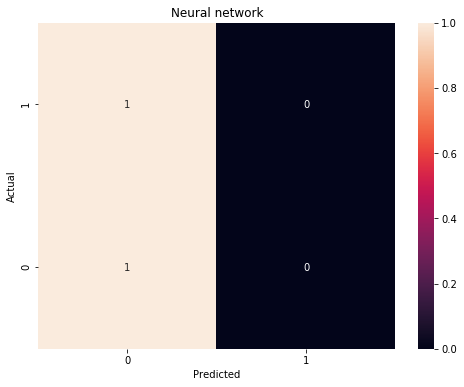

In [11]:
cm = confusion_matrix(y_test, rnd_y_hat)

plot_confusion_matrix(cm)

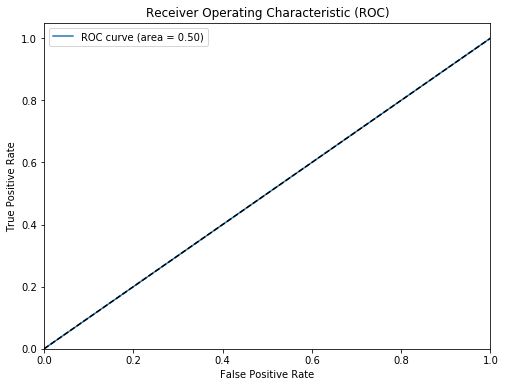

In [12]:
plot_roc(rnd_y_hat, y_test)

# Lo siguiente es para balancear los datos
https://imbalanced-learn.readthedocs.io/en/stable/over_sampling.html

In [13]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

x = rinon_df.loc[:, (rinon_df.columns != 'EXITOSO') & (rinon_df.columns != 'NO EXITOSO')]
y = rinon_df.loc[:, rinon_df.columns == 'EXITOSO']

os = SMOTE(random_state=0)
x_train_os, x_test_os, y_train_os, y_test_os = train_test_split(x, y, test_size=0.2, random_state=0)

cols = x_train_os.columns
os_data_x, os_data_y = os.fit_sample(x_train_os, y_train_os)

os_data_x = pd.DataFrame(data=os_data_x, columns=cols)

os_data_y = pd.DataFrame(data=os_data_y, columns=['EXITOSO','NO EXITOSO'])
os_data_y['NO EXITOSO'] = abs(os_data_y['EXITOSO']-1)

# we can Check the numbers of our data
print("length of oversampled data:",len(os_data_x))
print("Number of not succesful:",len(os_data_y[os_data_y['EXITOSO']==0]))
print("Number of succesful:",len(os_data_y[os_data_y['EXITOSO']==1]))
print("Proportion of not succesful data:",len(os_data_y[os_data_y['EXITOSO']==0])/len(os_data_x))
print("Proportion of succesful data:",len(os_data_y[os_data_y['EXITOSO']==1])/len(os_data_x))

length of oversampled data: 39796
Number of not succesful: 19898
Number of succesful: 19898
Proportion of not succesful data: 0.5
Proportion of succesful data: 0.5


In [14]:
x_train_os, x_test_os, y_train_os, y_test_os = train_test_split(os_data_x,
                                                                os_data_y,
                                                                test_size=0.2,
                                                                random_state=0)


x_train_os = x_train_os.to_numpy().astype('float32')
y_train_os = y_train_os.to_numpy().astype('float32')
x_test_os  = x_test_os.to_numpy().astype('float32')
y_test_os  = y_test_os.to_numpy().astype('float32')

numDt, szDt  = x_train_os.shape

In [15]:
nn1 = models.Sequential()
# La mejor hasta ahora: 200, 150, 100, 50
nn1.add(layers.Dense(units=250,activation='relu',input_shape=(szDt,)))
nn1.add(layers.Dropout(0.3))
nn1.add(layers.Dense(units=200,activation='relu'))
nn1.add(layers.Dropout(0.3))
nn1.add(layers.Dense(units=150,activation='relu'))
nn1.add(layers.Dropout(0.3))
nn1.add(layers.Dense(units=100,activation='relu'))
nn1.add(layers.Dropout(0.3))
nn1.add(layers.Dense(units=50,activation='relu'))
nn1.add(layers.Dropout(0.3))

# Capa de salida
nn1.add(layers.Dense(units=2, activation='softmax'))

In [16]:
nn1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 250)               9750      
_________________________________________________________________
dropout_5 (Dropout)          (None, 250)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 200)               50200     
_________________________________________________________________
dropout_6 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 150)               30150     
_________________________________________________________________
dropout_7 (Dropout)          (None, 150)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 100)              

In [17]:
nn1.compile(loss='categorical_crossentropy',  optimizer=sgd, metrics=['accuracy'])

In [18]:
history = nn1.fit(x = x_train_os,
                  y = y_train_os,
                  validation_split=.2,
                  epochs    =100,
                  shuffle   =True,
                  batch_size=128,
                  callbacks =[early_s],
                  verbose=0)

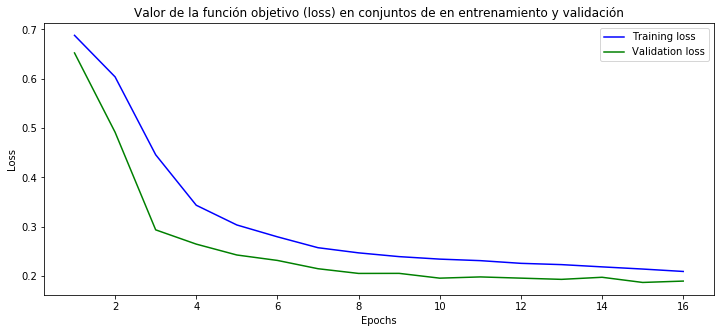

In [19]:
loss_values = history.history['loss']
val_loss_values = history.history['val_loss']

plot_loss(loss_values, val_loss_values, save=False)

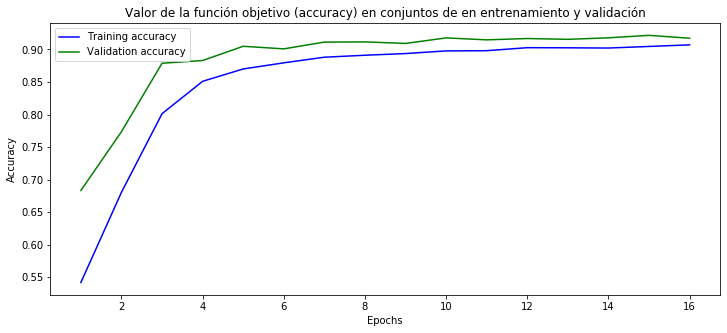

In [20]:
acc_values = history.history['accuracy']
val_acc_values = history.history['val_accuracy']

plot_accuracy(acc_values, val_acc_values, save=False)

In [21]:
print("Evaluate on test data")
results1 = nn1.evaluate(x_test_os, y_test_os, batch_size=128)
print("test loss, test acc:", results1)

y_hat_os = nn1.predict(x_test_os)
y_hat_os = y_hat_os[:,0]
y_test_os = y_test_os[:,0]

rnd_y_hat_os = np.round(y_hat_os)

Evaluate on test data
7960/7960 [==============================] - 0s 13us/step
test loss, test acc: [0.1966419870642262, 0.9131909608840942]


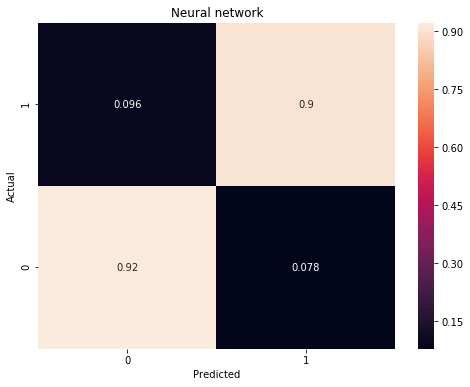

In [22]:
cm = confusion_matrix(y_test_os, rnd_y_hat_os)

plot_confusion_matrix(cm, save=False)
#plot_confusion_matrix(cm, normalized=False)

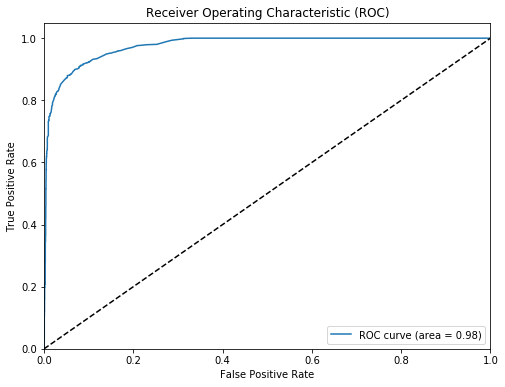

In [23]:
plot_roc(y_hat_os, y_test_os, save=False)

# Aquí comparamos con los datos originales

In [24]:
y_cols_bool = (rinon_df.columns == 'EXITOSO') | (rinon_df.columns == 'NO EXITOSO')
y_test_raw  = rinon_df[rinon_df['NO EXITOSO']==1].loc[:, y_cols_bool]
y_test_raw1 = rinon_df[rinon_df['EXITOSO']==1].loc[64641:, y_cols_bool]; n = len(y_test_raw)
y_test_raw  = pd.concat([y_test_raw, y_test_raw1], ignore_index=True)

x_cols_bool = (rinon_df.columns != 'EXITOSO') & (rinon_df.columns != 'NO EXITOSO')
x_test_raw  = rinon_df[rinon_df['NO EXITOSO']==1].loc[:, x_cols_bool]
x_test_raw1 = rinon_df[rinon_df['EXITOSO']==1].loc[64641:, x_cols_bool]; n = len(x_test_raw)
x_test_raw  = pd.concat([x_test_raw, x_test_raw1], ignore_index=True)

y_test_raw = y_test_raw.to_numpy().astype('float32')
x_test_raw = x_test_raw.to_numpy().astype('float32')

print("Prueba no exitosos (resultados):", n)
print("Prueba exitosos (resultados):", len(y_test_raw1))
print("Prueba totales (resultados):", len(y_test_raw))
print("\nPrueba no exitosos (características):", n)
print("Prueba exitosos (características):", len(x_test_raw1))
print("Prueba totales (características):", len(x_test_raw))

Prueba no exitosos (resultados): 357
Prueba exitosos (resultados): 357
Prueba totales (resultados): 714

Prueba no exitosos (características): 357
Prueba exitosos (características): 357
Prueba totales (características): 714


In [25]:
print("Evaluate on test data")
results_raw = nn1.evaluate(x_test_raw, y_test_raw, batch_size=128)
print("test lraws, test acc:", results_raw)

y_hat_raw = nn1.predict(x_test_raw)
y_hat_raw = y_hat_raw[:,0]
y_test_raw = y_test_raw[:,0]

rnd_y_hat_raw = np.round(y_hat_raw)

Evaluate on test data
714/714 [==============================] - 0s 32us/step
test lraws, test acc: [1.4415376602518124, 0.6176470518112183]


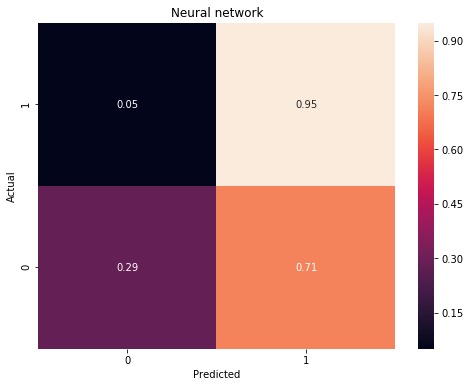

In [26]:
cm = confusion_matrix(y_test_raw, rnd_y_hat_raw)

plot_confusion_matrix(cm)
#plot_confusion_matrix(cm, normalized=False)

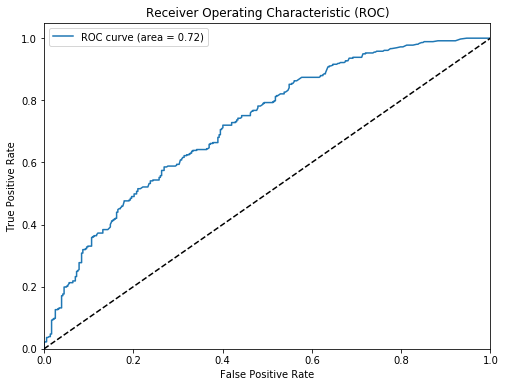

In [27]:
plot_roc(y_hat_raw, y_test_raw)